In [1]:
from quantumsim import *
from SurfaceCode import *
import tracemalloc

<h1> Four Cycle Block, surface code using QuantumSim </h1>
<img src="./pictures/four_cycle_surface_code_white_background.png" alt="Bit flip correction circuit" style="width:50%;"/>
<p> Connection notated as BLUE lines between ancillary qubit measures for BIT flips </>
<p> Connection notated as RED lines between ancillary qubit measures for PHASE flips </>

In [2]:
circuit = Circuit(4)

d1, d2, a1, a2 = 0, 1, 2, 3

# Encode state among two physical qubits
circuit.hadamard(d1)
circuit.cnot(d1, d2)

# Prepare anicallary qubits 
circuit.hadamard(a1)
circuit.hadamard(a2)

# Introduce bit flip on one data qubit
circuit.bitflip_error(d1)

# Introduce phase flip on one data qubit
# circuit.phaseflip_error(d2)

# Syndrome extraction 
circuit.cnot(a1, d1)
circuit.cnot(a1, d2)

# Syndrome extraction - Check for bit flips
circuit.controlled_pauli_z(a2, d1)
circuit.controlled_pauli_z(a2, d2)

# Prepare for measurement 
circuit.hadamard(a1)
circuit.hadamard(a2)

circuit.execute()
circuit.print_gates_and_descriptions()
circuit.measure(print_state=True)
print("A1: " + circuit.get_classical_state_of_qubit_as_string(a1))
print("A2: " + circuit.get_classical_state_of_qubit_as_string(a2))



H...	Hadamard on qubit 0
*X..	CNOT with control qubit 0 and target qubit 1
..H.	Hadamard on qubit 2
...H	Hadamard on qubit 3
X...	Bit-flip error (Pauli X) on qubit 0
X.*.	CNOT with control qubit 2 and target qubit 0
.X*.	CNOT with control qubit 2 and target qubit 1
Z..*	Controlled Pauli Z with control qubit 3 and target qubit 0
.Z.*	Controlled Pauli Z with control qubit 3 and target qubit 1
..H.	Hadamard on qubit 2
...H	Hadamard on qubit 3
Measured state:
|1001>
A1: |0>	 Measured value of qubit 2
A2: |1>	 Measured value of qubit 3


<h3> Four Cycle without controlled z (only CNOT's) </h3>

In [3]:
circuit = Circuit(4)

# Encode state among two physical qubits
circuit.hadamard(0)
circuit.cnot(0, 1)

# Prepare anicallary qubits 
circuit.hadamard(2)
# circuit.hadamard(3)

# Introduce bit flip on one data qubit
circuit.bitflip_error(0)

# Introduce phase flip on one data qubit
circuit.phaseflip_error(1)

# Syndrome extraction 
circuit.cnot(2, 0)
circuit.cnot(2, 1)

# Syndrome extraction - Check for bit flips
circuit.cnot(0, 3)
circuit.cnot(1, 3)

# Prepare for measurement 
circuit.hadamard(2)
# circuit.hadamard(3)

circuit.execute()
circuit.print_gates_and_descriptions()
circuit.measure(print_state=True)
print("A1: " + circuit.get_classical_state_of_qubit_as_string(2))
print("A2: " + circuit.get_classical_state_of_qubit_as_string(3))

H...	Hadamard on qubit 0
*X..	CNOT with control qubit 0 and target qubit 1
..H.	Hadamard on qubit 2
X...	Bit-flip error (Pauli X) on qubit 0
.Z..	Phase-flip error (Pauli Z) on qubit 1
X.*.	CNOT with control qubit 2 and target qubit 0
.X*.	CNOT with control qubit 2 and target qubit 1
*..X	CNOT with control qubit 0 and target qubit 3
.*.X	CNOT with control qubit 1 and target qubit 3
..H.	Hadamard on qubit 2
Measured state:
|1011>
A1: |1>	 Measured value of qubit 2
A2: |1>	 Measured value of qubit 3


<h1> Four Cycle Block, surface code using Qiskit </h1>

In [4]:
# from qiskit import QuantumCircuit
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
# from qiskit.providers.basic_provider import BasicSimulator
# from qiskit.visualization import plot_histogram

# # Create a new circuit with two qubits
# qc = QuantumCircuit(4, 2)

# qc.h(0)
# qc.cx(0, 1)

# qc.z(0)
# # qc.x(0)

# qc.h(2)
# qc.h(3)


# qc.cx(2, 0)
# qc.cx(2, 1)

# qc.cz(3, 0)
# qc.cz(3, 1)

# qc.h(2)
# qc.h(3)

# qc.measure(2, 0)
# qc.measure(3, 1)


# # Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# # last line of the cell, so the drawing appears in the cell output.
# # Remove the "mpl" argument to get a text drawing.
# qc.draw("mpl")

# # backend = BasicSimulator()
# # result = backend.run(qc, shots=100).result()   
# # counts = result.get_counts()                    
# # plot_histogram(counts)




findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: F

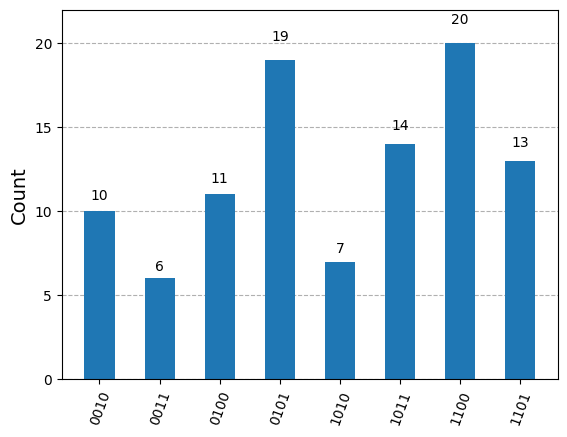

In [5]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram

# Create a new circuit with two qubits
qc = QuantumCircuit(9, 4)
d1, d2, d3, d4, d5, a1, a2, a3, a4 = 0, 1, 2, 3, 4, 5, 6, 7, 8

qc.h(d1)
qc.cx(d1, d2)
qc.cx(d2, d3)
qc.cx(d3, d4)
qc.cx(d4, d5)

# Introduce errors
qc.x(d1)
qc.z(d5)

# Measure bit flips (blue lines)
qc.cx(d1, a2)
qc.cx(d3, a2)
qc.cx(d4, a2)
qc.cx(d2, a3)
qc.cx(d3, a3)
qc.cx(d5, a3)
qc.h(a1)
qc.h(a4)
qc.cx(a1, d1)
qc.cx(a1, d2)
qc.cx(a1, d3)
qc.cx(a4, d3)
qc.cx(a4, d4)
qc.cx(a4, d5)
qc.h(a1)
qc.h(a4)

qc.measure(a1, 0)
qc.measure(a2, 1)
qc.measure(a3, 2)
qc.measure(a4, 3)



# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

backend = BasicSimulator()
result = backend.run(qc, shots=100).result()   
counts = result.get_counts()                    
plot_histogram(counts)

<h1> The [[5, 1, 2]] Detection code </h1>
<img src="./pictures/5_1_2_surface_code_white_background.png" alt="Bit flip correction circuit" style="width:50%;"/>

In [6]:
circuit = Circuit(9)
d1, d2, d3, d4, d5, a1, a2, a3, a4 = 0, 1, 2, 3, 4, 5, 6, 7, 8

# Encode data qubits
circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d2, d3)
circuit.cnot(d3, d4)
circuit.cnot(d4, d5)

# Introduce errors
# circuit.bitflip_error(d1)
# circuit.phaseflip_error(d5)



# Measure bit flips (blue lines)
circuit.cnot(d1, a2)
circuit.cnot(d3, a2)
circuit.cnot(d4, a2)

circuit.cnot(d2, a3)
circuit.cnot(d3, a3)
circuit.cnot(d5, a3)

circuit.hadamard(a1)
circuit.hadamard(a4)

circuit.cnot(a1, d1)
circuit.cnot(a1, d2)
circuit.cnot(a1, d3)

circuit.cnot(a4, d3)
circuit.cnot(a4, d4)
circuit.cnot(a4, d5)

circuit.hadamard(a1)
circuit.hadamard(a4)

circuit.execute()
# circuit.print_gates_and_descriptions()
circuit.measure(print_state=True)
print("A1: " + circuit.get_classical_state_of_qubit_as_string(a1))
print("A2: " + circuit.get_classical_state_of_qubit_as_string(a2))
print("A3: " + circuit.get_classical_state_of_qubit_as_string(a3))
print("A4: " + circuit.get_classical_state_of_qubit_as_string(a4))




Measured state:
|001110001>
A1: |0>	 Measured value of qubit 5
A2: |0>	 Measured value of qubit 6
A3: |0>	 Measured value of qubit 7
A4: |1>	 Measured value of qubit 8


findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: F

H....	Hadamard on qubit 0
*X...	CNOT with control qubit 0 and target qubit 1
.*X..	CNOT with control qubit 1 and target qubit 2
..*X.	CNOT with control qubit 2 and target qubit 3
X....	Bit-flip error (Pauli X) on qubit 0
*...X	CNOT with control qubit 0 and target qubit 4
.*..X	CNOT with control qubit 1 and target qubit 4
..*.X	CNOT with control qubit 2 and target qubit 4
...*X	CNOT with control qubit 3 and target qubit 4


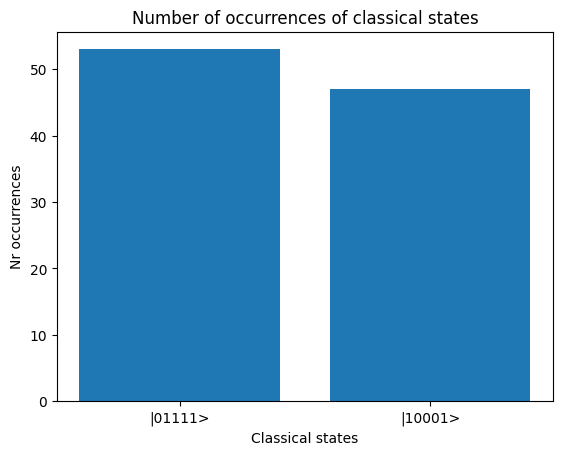

In [7]:
circuit = Circuit(5)

d1, d2, d3, d4, a1 = 0, 1, 2, 3, 4

circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d2, d3)
circuit.cnot(d3, d4)

circuit.bitflip_error(d1)

circuit.cnot(d1, a1)
circuit.cnot(d2, a1)
circuit.cnot(d3, a1)
circuit.cnot(d4, a1)

circuit.print_gates_and_descriptions()

result = QuantumUtil.run_circuit(circuit, 100)
QuantumUtil.histogram_of_classical_states(result)



In [ ]:
tracemalloc.start()
circuit = Circuit(5, True)

d1, d2, d3, d4, a1 = 0, 1, 2, 3, 4

circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d2, d3)
circuit.cnot(d3, d4)

circuit.phaseflip_error(d1)

circuit.hadamard(a1)

circuit.cnot(a1, d1)
circuit.cnot(a1, d2)
circuit.cnot(a1, d3)
circuit.cnot(a1, d4)

circuit.hadamard(a1)
circuit.print_gates_and_descriptions()
circuit.execute()
circuit.measure(True)

# result = QuantumUtil.run_circuit(circuit, 100)
# QuantumUtil.histogram_of_classical_states(result)

print(tracemalloc.get_traced_memory())
tracemalloc.stop()

H....	Hadamard on qubit 0
*X...	CNOT with control qubit 0 and target qubit 1
.*X..	CNOT with control qubit 1 and target qubit 2
..*X.	CNOT with control qubit 2 and target qubit 3
Z....	Phase-flip error (Pauli Z) on qubit 0
....H	Hadamard on qubit 4
X...*	CNOT with control qubit 4 and target qubit 0
.X..*	CNOT with control qubit 4 and target qubit 1
..X.*	CNOT with control qubit 4 and target qubit 2
...X*	CNOT with control qubit 4 and target qubit 3
....H	Hadamard on qubit 4
Measured state:
|11111>
(14842, 87310)


In [2]:

circuit = Circuit(6, True)

d1, d2, d3, d4, a1, a2 = 0, 1, 2, 3, 4, 5

circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d2, d3)
circuit.cnot(d3, d4)

# circuit.phaseflip_error(d1)
circuit.bitflip_error(d4)

circuit.cnot(d1, a2)
circuit.cnot(d2, a2)
circuit.cnot(d3, a2)
circuit.cnot(d4, a2)

circuit.hadamard(a1)

circuit.cnot(a1, d1)
circuit.cnot(a1, d2)
circuit.cnot(a1, d3)
circuit.cnot(a1, d4)

circuit.hadamard(a1)

circuit.print_gates_and_descriptions()

result = QuantumUtil.run_circuit(circuit, 100)
QuantumUtil.histogram_of_classical_states(result)

H.....	Hadamard on qubit 0
*X....	CNOT with control qubit 0 and target qubit 1
.*X...	CNOT with control qubit 1 and target qubit 2
..*X..	CNOT with control qubit 2 and target qubit 3
...X..	Bit-flip error (Pauli X) on qubit 3
*....X	CNOT with control qubit 0 and target qubit 5
.*...X	CNOT with control qubit 1 and target qubit 5
..*..X	CNOT with control qubit 2 and target qubit 5
...*.X	CNOT with control qubit 3 and target qubit 5
....H.	Hadamard on qubit 4
X...*.	CNOT with control qubit 4 and target qubit 0
.X..*.	CNOT with control qubit 4 and target qubit 1
..X.*.	CNOT with control qubit 4 and target qubit 2
...X*.	CNOT with control qubit 4 and target qubit 3
....H.	Hadamard on qubit 4


Exception: Direct Operation Execution is enabled, QuantumUtil not supported with this flag